# Pipe Flow Heat Transport PDE with Pyomo

Solving the heat transport equation for incompressible fluid flow in a horizontal pipe:

$$\frac{\partial T}{\partial t} + v(t) \frac{\partial T}{\partial x} = \alpha \frac{\partial^2 T}{\partial x^2} + \frac{q(t)}{\rho c_p}$$

Where:
- T(x,t) = temperature at position x and time t
- v(t) = time-varying fluid velocity
- α = thermal diffusivity
- q(t) = time-varying volumetric heat input rate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.dae import DerivativeVar, ContinuousSet
from pyomo.environ import (
    Var,
    Param,
    Constraint,
    Objective,
    SolverFactory,
    ConcreteModel,
    TransformationFactory,
    value
)

In [2]:
def create_pipe_flow_model(
    L=10.0,
    t_final=5.0,
    n_x=50,
    n_t=50,
    velocity_func=None,
    heat_func=None,
    inlet_func=None
):
    """
    Create Pyomo model for pipe flow heat transport PDE

    Parameters:
    L: pipe length
    t_final: final time
    n_x: number of spatial discretization points
    n_t: number of temporal discretization points
    velocity_func: function for v(t)
    heat_func: function for q(t)
    inlet_func: function for T_inlet(t)
    """

    model = ConcreteModel()

    # Define continuous sets for space and time
    model.x = ContinuousSet(bounds=(0, L))
    model.t = ContinuousSet(bounds=(0, t_final))

    # Temperature variable
    model.T = Var(model.t, model.x, bounds=(0, None))

    # Derivative variables
    model.dTdt = DerivativeVar(model.T, wrt=model.t)
    model.dTdx = DerivativeVar(model.T, wrt=model.x)
    model.d2Tdx2 = DerivativeVar(model.T, wrt=(model.x, model.x))

    # Physical parameters
    model.alpha = Param(initialize=0.01)  # thermal diffusivity [m²/s]
    model.rho = Param(initialize=800)   # density [kg/m³]
    model.cp = Param(initialize=4186)    # specific heat [J/kg·K]

    # Default parameter functions if none provided
    if velocity_func is None:
        def velocity_func(t):
            return 0.5  # + 0.1 * t / t_final

    if heat_func is None:
        def heat_func(t):
            return 1000

    if inlet_func is None:
        def inlet_func(t):
            return 273.15 + 50 + 5 * t / t_final

    # Store functions for later use
    model.velocity_func = velocity_func
    model.heat_func = heat_func
    model.inlet_func = inlet_func

    # Time-varying parameters (will be initialized after discretization)
    model.v = Param(model.t, mutable=True)
    model.q = Param(model.t, mutable=True)
    model.T_inlet = Param(model.t, mutable=True)

    return model

In [3]:
def add_pde_constraints(model):
    """
    Add PDE constraint and boundary/initial conditions
    """

    # Main PDE constraint
    @model.Constraint(model.t, model.x)
    def pde_constraint(m, t, x):
        # Skip boundary conditions - they're handled separately
        if t == 0:  # Skip initial time
            return Constraint.Skip
        if x == 0 or x == value(m.x.last()):  # Skip spatial boundaries
            return Constraint.Skip

        # PDE: ∂T/∂t + v(t)∂T/∂x = α∂²T/∂x² + q(t)/(ρcp)
        return (m.dTdt[t, x] + m.v[t] * m.dTdx[t, x] ==
                m.alpha * m.d2Tdx2[t, x] + m.q[t] / (m.rho * m.cp))

    # Initial condition: T(x, 0) = T₀(x)
    @model.Constraint(model.x)
    def initial_condition(m, x):
        if x == 0 or x == value(m.x.last()):
            return Constraint.Skip
        # Initial temperature distribution (example: linear profile)
        T_0 = 273.15 + 50.0
        return m.T[0, x] == T_0

    # Boundary condition at inlet: T(0, t) = T_inlet(t)
    @model.Constraint(model.t)
    def inlet_bc(m, t):
        return m.T[t, 0] == m.T_inlet[t]

    # Boundary condition at outlet: zero gradient (∂T/∂x = 0)
    @model.Constraint(model.t)
    def outlet_bc(m, t):
        return m.dTdx[t, value(m.x.last())] == 0

    # Dummy objective (required by Pyomo)
    model.obj = Objective(expr=1)

    return model

In [4]:
def solve_model(model, n_x=50, n_t=50):
    """
    Discretize and solve the PDE model
    """

    # Apply finite difference discretization
    # Spatial discretization (backward difference for convection stability)
    TransformationFactory('dae.finite_difference').apply_to(
        model, nfe=n_x, scheme='BACKWARD', wrt=model.x
    )

    # Temporal discretization (forward difference)
    TransformationFactory('dae.finite_difference').apply_to(
        model, nfe=n_t, scheme='FORWARD', wrt=model.t
    )

    # Initialize time-varying parameters after discretization using stored functions
    for t in model.t:
        model.v[t].set_value(model.velocity_func(t))
        model.q[t].set_value(model.heat_func(t))
        model.T_inlet[t].set_value(model.inlet_func(t))

    # Solve with IPOPT
    solver = SolverFactory('ipopt')
    results = solver.solve(model, tee=True)

    return results

In [11]:
def plot_results(model, figsize=(12, 8)):
    """
    Plot the temperature field solution
    """

    # Extract solution data
    t_vals = sorted(model.t)
    x_vals = sorted(model.x)

    # Create meshgrid
    T_grid, X_grid = np.meshgrid(t_vals, x_vals, indexing='ij')

    # Extract temperature values
    temp_vals = np.array([
        [value(model.T[t, x]) for x in x_vals] for t in t_vals
    ])

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

    # 1. 3D surface plot
    ax1.remove()
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    surf = ax1.plot_surface(X_grid, T_grid, temp_vals, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Position x [m]')
    ax1.set_ylabel('Time t [s]')
    ax1.set_zlabel('Temperature T [K]')
    ax1.set_title('Temperature Field T(x,t)')

    # 2. Contour plot
    #ax2 = fig.add_subplot(2, 2, 2)
    contour = ax2.contourf(X_grid, T_grid, temp_vals, levels=20, cmap='viridis')
    ax2.set_xlabel('Position x [m]')
    ax2.set_ylabel('Time t [s]')
    ax2.set_title('Temperature Contours')
    cbar2 = plt.colorbar(contour, ax=ax2)
    cbar2.set_label('Temperature [K]')

    # 3. Temperature profiles at different times
    #ax3 = fig.add_subplot(2, 2, 3)
    time_indices = [0, len(t_vals)//4, len(t_vals)//2, 3*len(t_vals)//4, -1]
    for i in time_indices:
        ax3.plot(x_vals, temp_vals[i], label=f't = {t_vals[i]:.2f}s', linewidth=2)
    ax3.set_xlabel('Position x [m]')
    ax3.set_ylabel('Temperature T [K]')
    ax3.set_title('Temperature Profiles at Different Times')
    ax3.legend(frameon=True, fancybox=True, shadow=True)
    ax3.grid(True, alpha=0.3)
    
    # Set y-axis formatting for temperature profiles
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
    
    # Clear any duplicate ticks and ensure proper spacing
    ax3.tick_params(axis='y', which='major', labelsize=10)
    ax3.tick_params(axis='y', which='minor', labelsize=8)

    # 4. Temperature evolution at different positions
    #ax4 = fig.add_subplot(2, 2, 4)
    pos_indices = [0, len(x_vals)//4, len(x_vals)//2, 3*len(x_vals)//4, -1]
    for j in pos_indices:
        ax4.plot(t_vals, temp_vals[:, j], label=f'x = {x_vals[j]:.2f}m', linewidth=2)
    ax4.set_xlabel('Time t [s]')
    ax4.set_ylabel('Temperature T [K]')
    ax4.set_title('Temperature Evolution at Different Positions')
    ax4.legend(frameon=True, fancybox=True, shadow=True)
    ax4.grid(True, alpha=0.3)
    
    # Set y-axis formatting for temperature evolution
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
    
    # Clear any duplicate ticks and ensure proper spacing
    ax4.tick_params(axis='y', which='major', labelsize=10)
    ax4.tick_params(axis='y', which='minor', labelsize=8)
    
    # Force y-axis limits and ticks to be clean
    temp_min = np.min(temp_vals)
    temp_max = np.max(temp_vals)
    temp_range = temp_max - temp_min
    
    # Set consistent y-limits for both temperature plots
    y_min = temp_min - 0.05 * temp_range
    y_max = temp_max + 0.05 * temp_range
    
    ax3.set_ylim(y_min, y_max)
    ax4.set_ylim(y_min, y_max)
    
    # Set explicit y-ticks to avoid overlapping labels
    n_ticks = 6
    y_ticks = np.linspace(y_min, y_max, n_ticks)
    ax3.set_yticks(y_ticks)
    ax4.set_yticks(y_ticks)

    plt.tight_layout()
    return fig

Creating pipe flow heat transport model...
Adding PDE constraints...
Solving the discretized PDE...
Ipopt 3.14.19: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    19837
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     6259
                     variables with only lower bounds:     1581
                variables with lower and upper bounds:        0
                     variables with only

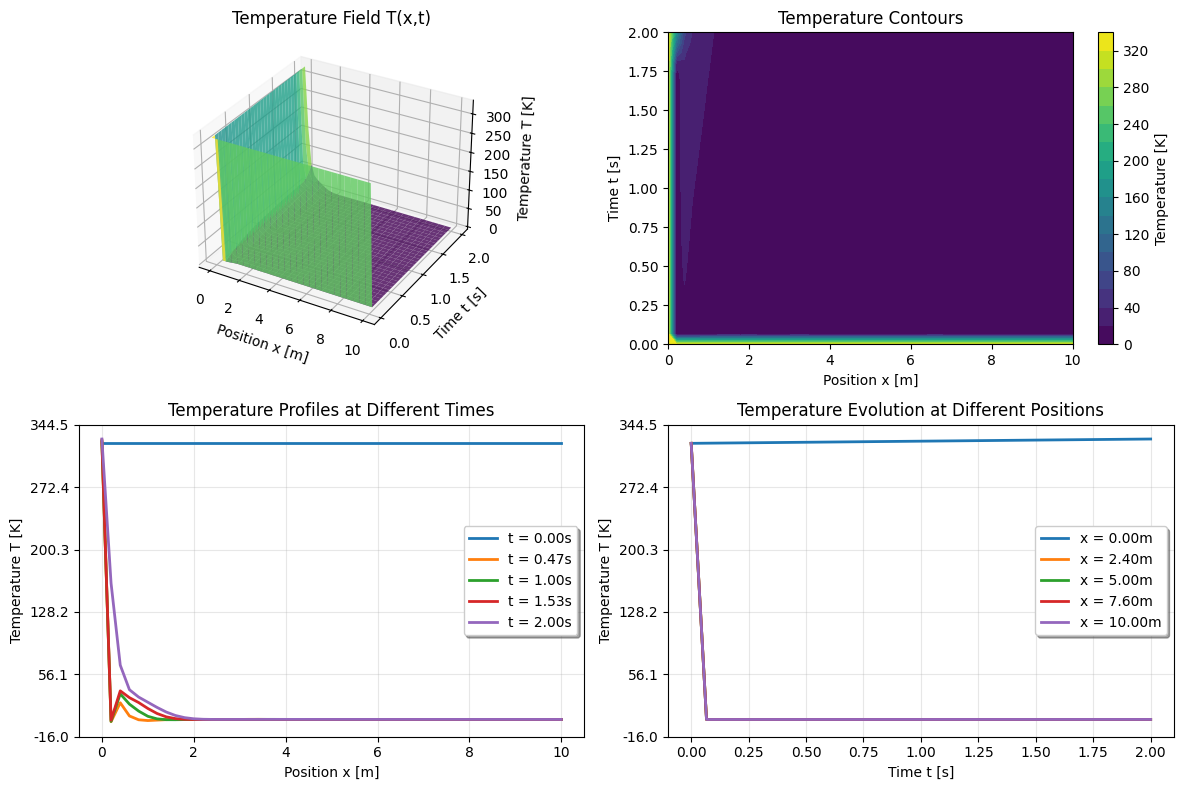

In [15]:
# Create and solve the model
print("Creating pipe flow heat transport model...")
model = create_pipe_flow_model(L=10.0, t_final=2.0)

print("Adding PDE constraints...")
model = add_pde_constraints(model)

print("Solving the discretized PDE...")
results = solve_model(model, n_x=50, n_t=30)

print(f"Solver status: {results.solver.status}")
print(f"Termination condition: {results.solver.termination_condition}")

if results.solver.termination_condition == 'optimal':
    print("Plotting results...")
    fig = plot_results(model)
    plt.show()
elif results.solver.termination_condition == 'locallyOptimal':
    print("Solution found (locally optimal). Plotting results...")
    fig = plot_results(model)
    plt.show()
else:
    print("Solution not optimal. Check model formulation.")
    print(f"Solver message: {results.solver.message}")

In [7]:
# Alternative: Run with different parameter functions
def run_with_custom_functions():
    """
    Example with different velocity and heat input functions
    """

    # Define custom parameter functions
    def step_velocity(t):
        return 2.0 if t > 2.0 else 1.0

    def pulse_heat(t):
        return 2000 if 1.0 < t < 3.0 else 500

    def sine_inlet(t):
        return 300 + 10 * np.sin(2 * np.pi * t / 4.0)

    # Create model with custom functions
    model = create_pipe_flow_model(L=8.0, t_final=4.0,
                                  velocity_func=step_velocity,
                                  heat_func=pulse_heat,
                                  inlet_func=sine_inlet)

    model = add_pde_constraints(model)
    results = solve_model(model, n_x=25, n_t=25)

    if results.solver.termination_condition == 'optimal':
        fig = plot_results(model)
        plt.suptitle('Pipe Flow with Step Velocity and Pulse Heat Input')
        plt.show()

    return model, results

# Uncomment to run alternative scenario
# custom_model, custom_results = run_with_custom_functions()